# The Guardian Opem platformm API
- https://open-platform.theguardian.com

In [2]:
# inspired but totally modifed https://github.com/janlukasschroeder/netflix-stock-price-impacted-by-news

from datetime import datetime

# Define the YEAR
YEAR = 2023

# Define the quarters
quarters = {
    "Q1": {"start": datetime(YEAR, 1, 1).date(), "end": datetime(YEAR, 3, 31).date()},
    "Q2": {"start": datetime(YEAR, 4, 1).date(), "end": datetime(YEAR, 6, 30).date()},
    "Q3": {"start": datetime(YEAR, 7, 1).date(), "end": datetime(YEAR, 9, 30).date()},
    "Q4": {"start": datetime(YEAR, 10, 1).date(), "end": datetime(YEAR, 12, 31).date()},
    "TEST": {"start": datetime(YEAR, 9, 15).date(), "end": datetime(YEAR, 9, 25).date()},
}

# Access the concrete quarter
quarter = quarters['Q4']

# Access a specific quarter
print(f"start: {quarter['start']} \nend:   {quarter['end']}")

start: 2023-10-01 
end:   2023-12-31


In [3]:
# Allow to display charts in the browser
%matplotlib inline

API_KEY = "cb585bc0-76e2-49fe-a635-277e94cbeba8"

section = "section=(business|money|technology)"
from_date = f"from-date={quarter['start']}"
to_date = f"to-date={quarter['end']}"
order_by = "order-by=oldest"
use_date = "use-date=published"
show_references = "show-references=reuters-stock-ric"
page_size = "page-size=200"
query = "q=Apple"
api_key = f"api-key={API_KEY}"

query_string = f"{section}&{from_date}&{to_date}&{order_by}&{show_references}&{page_size}&{query}"
api = f"https://content.guardianapis.com/search?{query_string}&{api_key}"

In [4]:
import requests
import time 

try:    
    response = requests.get(api)
    json_response = response.json()

    pages = json_response['response']['pages']

    articles = json_response['response']['results']

    for page in range(2, pages+1):
        time.sleep(1)
        api = f"https://content.guardianapis.com/search?{query_string}&page={page}&{api_key}"
        response = requests.get(api)
        json_response = response.json()
        articles += json_response['response']['results']

except requests.exceptions.HTTPError as errh:
    print ("Http Error:",errh)
except requests.exceptions.ConnectionError as errc:
    print ("Error Connecting:",errc)
except requests.exceptions.Timeout as errt:
    print ("Timeout Error:",errt)
except requests.exceptions.RequestException as e: 
    raise SystemExit(e) 



In [5]:
print(len(articles))
display(articles)

83


[{'id': 'technology/2023/oct/01/apple-says-software-bug-and-certain-apps-causing-iphone-15-overheating',
  'type': 'article',
  'sectionId': 'technology',
  'sectionName': 'Technology',
  'webPublicationDate': '2023-10-01T15:23:40Z',
  'webTitle': 'Apple says software bug and certain apps causing iPhone overheating',
  'webUrl': 'https://www.theguardian.com/technology/2023/oct/01/apple-says-software-bug-and-certain-apps-causing-iphone-15-overheating',
  'apiUrl': 'https://content.guardianapis.com/technology/2023/oct/01/apple-says-software-bug-and-certain-apps-causing-iphone-15-overheating',
  'references': [{'id': 'reuters-stock-ric/AAPL.O',
    'type': 'reuters-stock-ric'}],
  'isHosted': False,
  'pillarId': 'pillar/news',
  'pillarName': 'News'},
 {'id': 'money/2023/oct/02/from-root-to-tip-how-to-stop-food-waste-and-save',
  'type': 'article',
  'sectionId': 'money',
  'sectionName': 'Money',
  'webPublicationDate': '2023-10-02T08:00:07Z',
  'webTitle': 'From root to tip … how to st

In [6]:
# Filter articles which has in references array 'id': 'reuters-stock-ric/AAPL.O'
# articles = [article for article in articles if any(ref.get('id') == 'reuters-stock-ric/AAPL.O' for ref in article['references'])]
# print(len(articles))

In [7]:
#!pip install yfinance
import yfinance as yf

_start = from_date.split("=")[1]
_end = to_date.split("=")[1]

quotes = yf.download("AAPL", rounding=True, start=_start, end=_end)
display(quotes)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-02,171.22,174.30,170.93,173.75,173.52,52164500
2023-10-03,172.26,173.63,170.82,172.40,172.17,49594600
2023-10-04,171.09,174.21,170.97,173.66,173.43,53020300
2023-10-05,173.79,175.45,172.68,174.91,174.68,48527900
2023-10-06,173.80,177.99,173.18,177.49,177.26,57224100
...,...,...,...,...,...,...
2023-12-22,195.18,195.41,192.97,193.60,193.60,37122800
2023-12-26,193.61,193.89,192.83,193.05,193.05,28919300
2023-12-27,192.49,193.50,191.09,193.15,193.15,48087700


In [8]:
import pandas as pd
from datetime import datetime

# Get news volume for each day
def get_news_volume(articles, quotes) -> dict:
    news_volume = {}
    for article in articles:
        date_str = article['webPublicationDate'].split("T")[0]
        date = pd.Timestamp(datetime.strptime(date_str, '%Y-%m-%d').date())
        if date in news_volume:
            news_volume[date] += 1
        else:
            news_volume[date] = 1
        # Make sure that a bin exists for each day we have price data
    for date in quotes.index:
        news_volume[date] = news_volume[date] if date in news_volume else 0

    news_volume = dict(sorted(news_volume.items()))
    
    return news_volume
    

In [9]:
news_volume = get_news_volume(articles, quotes)
for date, volume in news_volume.items():
    print(f"{date} | {volume} | {date.strftime('%A')}")  
    

2023-10-01 00:00:00 | 1 | Sunday
2023-10-02 00:00:00 | 1 | Monday
2023-10-03 00:00:00 | 1 | Tuesday
2023-10-04 00:00:00 | 1 | Wednesday
2023-10-05 00:00:00 | 0 | Thursday
2023-10-06 00:00:00 | 0 | Friday
2023-10-09 00:00:00 | 1 | Monday
2023-10-10 00:00:00 | 1 | Tuesday
2023-10-11 00:00:00 | 3 | Wednesday
2023-10-12 00:00:00 | 0 | Thursday
2023-10-13 00:00:00 | 0 | Friday
2023-10-15 00:00:00 | 2 | Sunday
2023-10-16 00:00:00 | 2 | Monday
2023-10-17 00:00:00 | 1 | Tuesday
2023-10-18 00:00:00 | 2 | Wednesday
2023-10-19 00:00:00 | 3 | Thursday
2023-10-20 00:00:00 | 0 | Friday
2023-10-23 00:00:00 | 3 | Monday
2023-10-24 00:00:00 | 1 | Tuesday
2023-10-25 00:00:00 | 2 | Wednesday
2023-10-26 00:00:00 | 2 | Thursday
2023-10-27 00:00:00 | 0 | Friday
2023-10-28 00:00:00 | 1 | Saturday
2023-10-30 00:00:00 | 3 | Monday
2023-10-31 00:00:00 | 1 | Tuesday
2023-11-01 00:00:00 | 1 | Wednesday
2023-11-02 00:00:00 | 1 | Thursday
2023-11-03 00:00:00 | 0 | Friday
2023-11-06 00:00:00 | 1 | Monday
2023-11-07 

In [10]:
quotes['News Volume'] = 0

temp_volume = 0

for date, volume in news_volume.items():
    if date in quotes.index:
        # Add the volume of the current day and the volume of the previous days not in quotes
        quotes.loc[date, 'News Volume'] = volume + temp_volume
        temp_volume = 0
    else:
        # Accumulate the volume of the days not in quotes
        temp_volume += volume

# Convert 'News Volume' to integer type
quotes['News Volume'] = quotes['News Volume'].astype(int)        

In [11]:
display(quotes)

,Open,High,Low,Close,Adj Close,Volume,News Volume
Date,,,,,,,
2023-10-02,171.22,174.30,170.93,173.75,173.52,52164500,2
2023-10-03,172.26,173.63,170.82,172.40,172.17,49594600,1
2023-10-04,171.09,174.21,170.97,173.66,173.43,53020300,1
2023-10-05,173.79,175.45,172.68,174.91,174.68,48527900,0
2023-10-06,173.80,177.99,173.18,177.49,177.26,57224100,0
...,...,...,...,...,...,...,...
2023-12-22,195.18,195.41,192.97,193.60,193.60,37122800,0
2023-12-26,193.61,193.89,192.83,193.05,193.05,28919300,4
2023-12-27,192.49,193.50,191.09,193.15,193.15,48087700,0


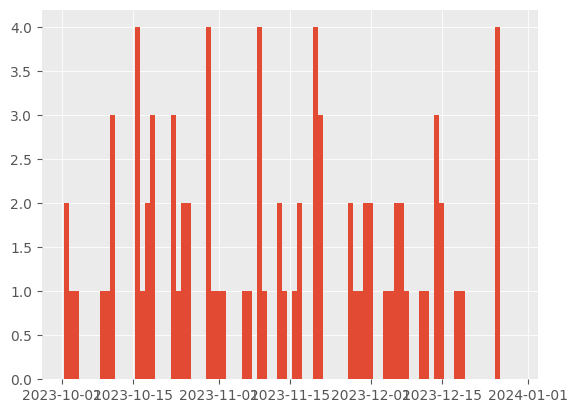

In [54]:
import matplotlib.pyplot as plt

# Set ggplot styles and update Matplotlib with them.
ggplot_styles = {
    'axes.edgecolor': 'white',
    'axes.facecolor': 'EBEBEB',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': 'white',
    'grid.linewidth': '0.6',
    'xtick.major.bottom': True,
    'xtick.minor.bottom': False,
    'ytick.major.left': True,
    'ytick.minor.left': False,
}

plt.rcParams.update(ggplot_styles)

plt.bar(quotes.index, quotes['News Volume'], width=1)
plt.show()

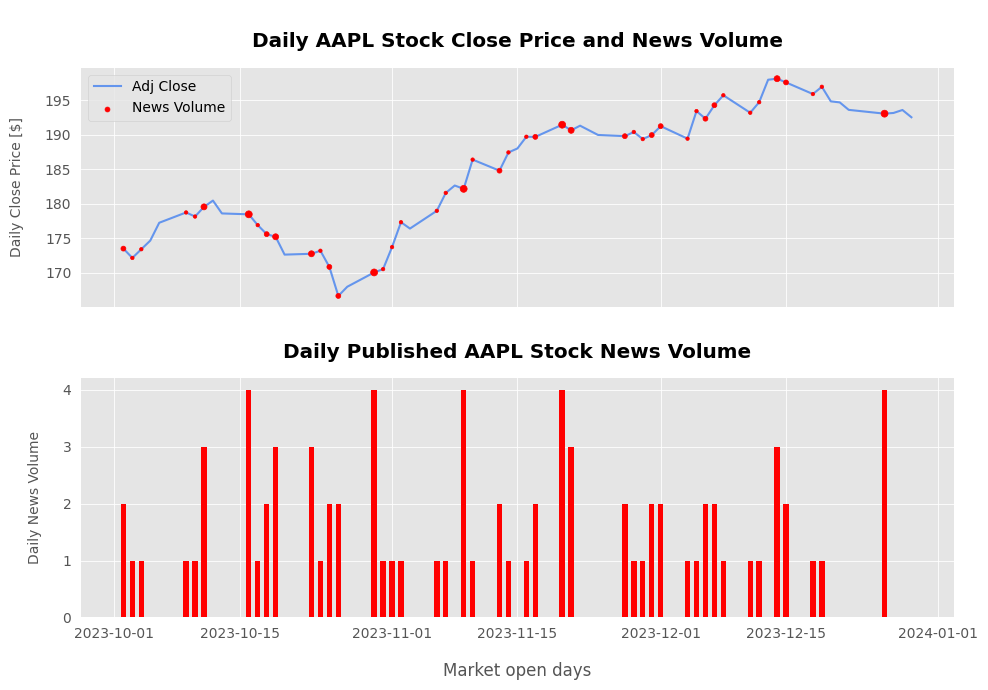

In [83]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Set the style of the plot
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 7))

# Plot the adjusted close prices
ax1.set_title('\nDaily AAPL Stock Close Price and News Volume', pad=15, weight='bold')
ax1.set_ylabel(r'Daily Close Price [\$]', labelpad=15, fontsize='medium')
ax1.plot(quotes.index.to_numpy(), quotes['Adj Close'].to_numpy(), label='Adj Close', color='cornflowerblue')
ax1.grid(True)
ax1.tick_params(bottom=False, left=False)

# Normalize the news volume for marker size
max_news_volume = quotes['News Volume'].max()
normalized_news_volume = (quotes['News Volume'] / max_news_volume) * 25

# Plot the news volume as red dots on the price chart
ax1.scatter(quotes.index, quotes['Adj Close'], label='News Volume', color='red', s=normalized_news_volume, zorder=2)

# Plot the news volume as a bar chart
ax2.set_title('Daily Published AAPL Stock News Volume', pad=15, weight='bold')
ax2.set_xlabel('Market open days', labelpad=15)
ax2.set_ylabel('Daily News Volume', labelpad=15, fontsize='medium')
ax2.bar(quotes.index, quotes['News Volume'], width=0.6, color='red', zorder=1)
ax2.grid(True)
ax2.tick_params(bottom=False, left=False)
# Set the y-axis to display only integer values
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

# Display the legend
ax1.legend()

# Adjust layout for better spacing
fig.tight_layout()

# Add space between ax1 and ax2
plt.subplots_adjust(hspace = 0.3)

plt.show()

In [ ]:
# rsvg-convert -f pdf -o news_volume_impact_stock_price.pdf news_volume_impact_stock_price.svg